<a href="https://colab.research.google.com/github/yecatstevir/teambrainiac/blob/main/source/SVM_Group_YA_Whole_brain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Whole Brain Support Vector Machine Training
- Go to 'Runtime' in Colab browser bar, select 'Change Runtime Type', select 'High-RAM' from 'Runtime Shape'. 
- load local pickle file containing all masked, normalized Whole Brain subject data in numpy matrix format
- SVM training per group (subject ids of '100XX-XXXXX' for Adolescent (child) and '300XX-XXXXX' for Young Adult)

### Mount Google Drive and clone repository
- open to source directory

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')#, force_remount = True)

Mounted at /content/gdrive


In [2]:
# Clone the entire repo.
!git clone -l -s https://github.com/yecatstevir/teambrainiac.git
# Change directory into cloned repo
%cd teambrainiac/source
!ls


Cloning into 'teambrainiac'...
remote: Enumerating objects: 488, done.
remote: Counting objects: 100% (488/488), done.
remote: Compressing objects: 100% (329/329), done.
remote: Total 488 (delta 293), reused 301 (delta 145), pack-reused 0
Receiving objects: 100% (488/488), 59.11 MiB | 13.88 MiB/s, done.
Resolving deltas: 100% (293/293), done.
/content/teambrainiac/source
Access_Load_Data.ipynb		  Mat_to_Numpy.ipynb
All_subject_masked_labeled.ipynb  models
cross_validation.py		  percent_signal_change.ipynb
data				  process.py
Explore_data.ipynb		  SVM_Group_Child_Whole_Brain.ipynb
explore.py			  SVM_Group_YA_Whole_brain.ipynb
Images				  utils.py
__init__.py			  Visualize_Data.ipynb
Masking.ipynb


### Load path_config.py 
- we are already in source so we can just load this file without chanding directory

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving path_config.py to path_config.py
User uploaded file "path_config.py" with length 228 bytes


#### Import libraries


In [ ]:
# Import libraries
!pip install boto3 nilearn
import pickle
from utils import *
from process import *
from cross_validation import *
from sklearn.svm import SVC
import numpy as np
from sklearn.metrics import accuracy_score
import pandas as pd

### Load Data from AWS and create Train/Val/Test splits

In [21]:
%%time
pkl_file = "whole_brain_all_norm_2d.pkl" # normalized
#pkl_file = 'all_data_dictionary.pkl' #Unnormalized
bool_mat = False
data = access_load_data(pkl_file, bool_mat)

CPU times: user 1min 7s, sys: 1min 39s, total: 2min 47s
Wall time: 2min 49s


In [6]:
#open path dictionary file to get subject ids
path = "data/data_path_dictionary.pkl"
data_path_dict = open_pickle(path)
subject_ids = data_path_dict['subject_ID']

# Split dataset into young children and older children/young adults
child = subject_ids[:33]
teen_plus = subject_ids[33:]
print("Number of subjects for child and teens", len(child), len(teen_plus))

Number of subjects for child and teens 33 19


#Time Series Cross Validation
## Organize Data Young Adults for Cross Validation
If we are performing cross validation, we need to get the data without custom splitting 

In [12]:
%%time 

#Function Calls
group_sub_ids = teen_plus # child, teen_plus
runs_train = 1 # Grab run 2 (0 indexing)
runs_test = 2 # Grab run 3 (0 indexing)
norm = False #"RUNS", "SUBJECT", False 

X, y = data_for_cv(data, group_sub_ids, runs_train, runs_test, norm)

Normalizing Each based on False...
X train data shape after concantenation (2772, 237979)
y train data shape after concantenation (2772,)
X test data shape after concantenation (2772, 237979)
y test data shape after concantenation (2772,)
Final X data shape to feed into Time Series Cross Validation (5544, 237979)
Final y data shape to feed into Time Series Cross Validation (5544,)
CPU times: user 2.25 s, sys: 4.42 s, total: 6.67 s
Wall time: 6.62 s


### Run the Time Series Cross Validation

In [ ]:
max_train = 1596
test_size = None
splits = 5

time_series_cv(X, y, max_train, test_size, splits)

# Young Adults
- Split subject IDs three ways to make Train, Val, Test sets
- Perform Z-Normalization on the data per run per subject by calling transform_data()
- Data is now ready to perform SVM()

In [22]:
# get train, test val data
train_ids = teen_plus[:16]
val_ids = teen_plus[16:20]
test_ids = teen_plus

group_sub_ids = (train_ids, val_ids, test_ids)
runs_train = 1 # grabs the second run
runs_test = 2 # grabds the third run
norm = "RUNS" # "RUNS" Normalizes per run; "SUBJECT" Normalized all runs for a given subject; False - no normalization

print("Number of Youth training examples: ", len(train_ids))
print("Number of Youth validation examples: ", len(val_ids))
print("Number of Youth testing examples: ", len(test_ids))
print(len(teen_plus))

# Get all the data we need for SVM
X, y, X_v, y_v, X_t, y_t = transform_data(data, group_sub_ids, runs_train, runs_val, runs_test, norm)

Number of Youth training examples:  16
Number of Youth validation examples:  3
Number of Youth testing examples:  19
19
Normalizing Each based on RUNS...
X train data shape after concantenation (1344, 237979)
y train data shape after concantenation (1344,)
X test data shape after concantenation (1596, 237979)
y test data shape after concantenation (1596,)
X val data shape after concantenation (252, 237979)
y val data shape after concantenation (252,)
Final X Train data shape (1344, 237979)
Final y Train data shape  (1344,)
Final X Val data shape (252, 237979)
Final y Val data shape  (252,)
Final X Test data shape (1596, 237979)
Final y Test data shape  (1596,)


# SVM Young Adult
- Run SVM on PSC and Z-normalized Data
- Train/Val set run 2
- Test set run 3

In [26]:
%%time
model_name = f"YA_svm_train_test{runs_train}_{runs_test}_1"
clfy = SVC(C = 5.0 , class_weight= 'balanced', max_iter = 1000, random_state = 42) #probability = True
clfy.fit(X, y)
f = open("models/%s.pkl"%model_name,"wb")
pickle.dump(clfy, f)
f.close()

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


CPU times: user 9min 16s, sys: 2min 18s, total: 11min 34s
Wall time: 1min 36s


### Validation prediction

In [27]:
%%time
yvaly_pred = clfy.predict(X_v)

# Model Accuracy
print("Accuracy:", accuracy_score(y_v, yvaly_pred))

Accuracy: 0.753968253968254
CPU times: user 7min 42s, sys: 17min 40s, total: 25min 22s
Wall time: 3min 13s


#### Held Out Test Set Prediction

In [28]:
%%time
ytesty_pred = clfy.predict(X_t)

# Model Accuracy
print("Accuracy:", accuracy_score(y_t, ytesty_pred))

Accuracy: 0.800125313283208
CPU times: user 47min 23s, sys: 1h 49min 8s, total: 2h 36min 31s
Wall time: 19min 56s


#### Check Support Vectors

In [29]:
print("number of support vectors:", len(clfy.support_))
print("indices of support vectors:", clfy.support_)

number of support vectors: 1204
indices of support vectors: [  14   15   16 ... 1333 1335 1336]


In [30]:
clfy.support_vectors_.shape

(1204, 237979)

In [31]:
# number of support vectors for each class
clfy.n_support_

array([610, 594], dtype=int32)

In [32]:
# Values scaled to fit between -1 and 1 
clfy.dual_coef_

array([[-0.5941178 , -0.7073968 , -0.20300861, ...,  0.81701869,
         0.31849093,  0.73213399]])

In [34]:
clfy.dual_coef_.shape


(1, 1204)

In [35]:
clfy.support_.shape

(1204,)

#### Create Beta map for Visualization
- Create Alphas

In [44]:
alphas = np.zeros((1344))
alphas[clfy.support_] = clfy.dual_coef_ #Load the weights corresponding to where support vectors are 
alphas.shape

(1344,)

In [45]:
alphas = alphas.reshape(1,-1)
alphas.shape

(1, 1344)

- Create Betas

In [46]:
mask_data_path = data_path_dict['mask_data'][0]
mask_type_dict = access_load_data(mask_data_path,True)
np_array_mask = mask_type_dict['mask']
print("mask shape:", np_array_mask.shape)

indices_mask = np.where(np_array_mask==1) # gets the indices where the mask is 1, the brain region for x, y, z planes
indices_mask

mask shape: (79, 95, 79)


(array([ 3,  3,  3, ..., 75, 75, 75]),
 array([36, 36, 36, ..., 47, 47, 47]),
 array([33, 34, 35, ..., 28, 29, 30]))

In [48]:
bmap = np.dot(alphas, X)
print("Shape of beta map: ", bmap.shape)
bmap

Shape of beta map:  (1, 237979)


array([[16.54036726, 11.7424786 ,  3.53710205, ..., 46.9954873 ,
        27.52067236,  0.18643079]])

In [49]:
bmap2 = np.zeros((79,95,79))

# Grab the areas not masked out of the brain to recreate the brain using highlighted areas
bmap2[indices_mask] = bmap
bmap2

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [50]:
bmap2.shape

(79, 95, 79)

### Threshold map

In [ ]:
from IPython.core.display import HTML, Markdown, display

import numpy.random as npr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.formula.api as smf

import ipywidgets as widgets

import requests
import zipfile
import os
import nibabel
from scipy.stats import gamma

In [ ]:
"""
code from web source
# use some numpy magic to get an array that is nan everywhere that the correlation value is less than .2

# first make a copy of the correlation values
r_thresholded = r_values_as_slice.copy()

# now set any values less than .2 to be equal to nan
r_thresh = .2
r_thresholded[r_thresholded < r_thresh] = np.nan

# Ok now lets visualize all the maps
fig, ax = plt.subplots(1,3,figsize=(18, 6))

# Create the plots
ax[0].imshow(functional_data[:,:,36,10], cmap='gray')
ax[0].set_title('brain slice', fontsize=25)
ax[0].set_xticks([])
ax[0].set_yticks([])


ax[1].imshow(r_values_as_slice,  cmap='afmhot')
ax[1].set_title('un-thresholded map', fontsize=25)
ax[1].set_xticks([])
ax[1].set_yticks([])


ax[2].imshow(functional_data[:,:,36,10], cmap='gray')
ax[2].imshow(r_thresholded, cmap='afmhot')
ax[2].set_title('thresholded map (r > ' + str(r_thresh) + ')', fontsize=25)
ax[2].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])"""

IndexError: ignored

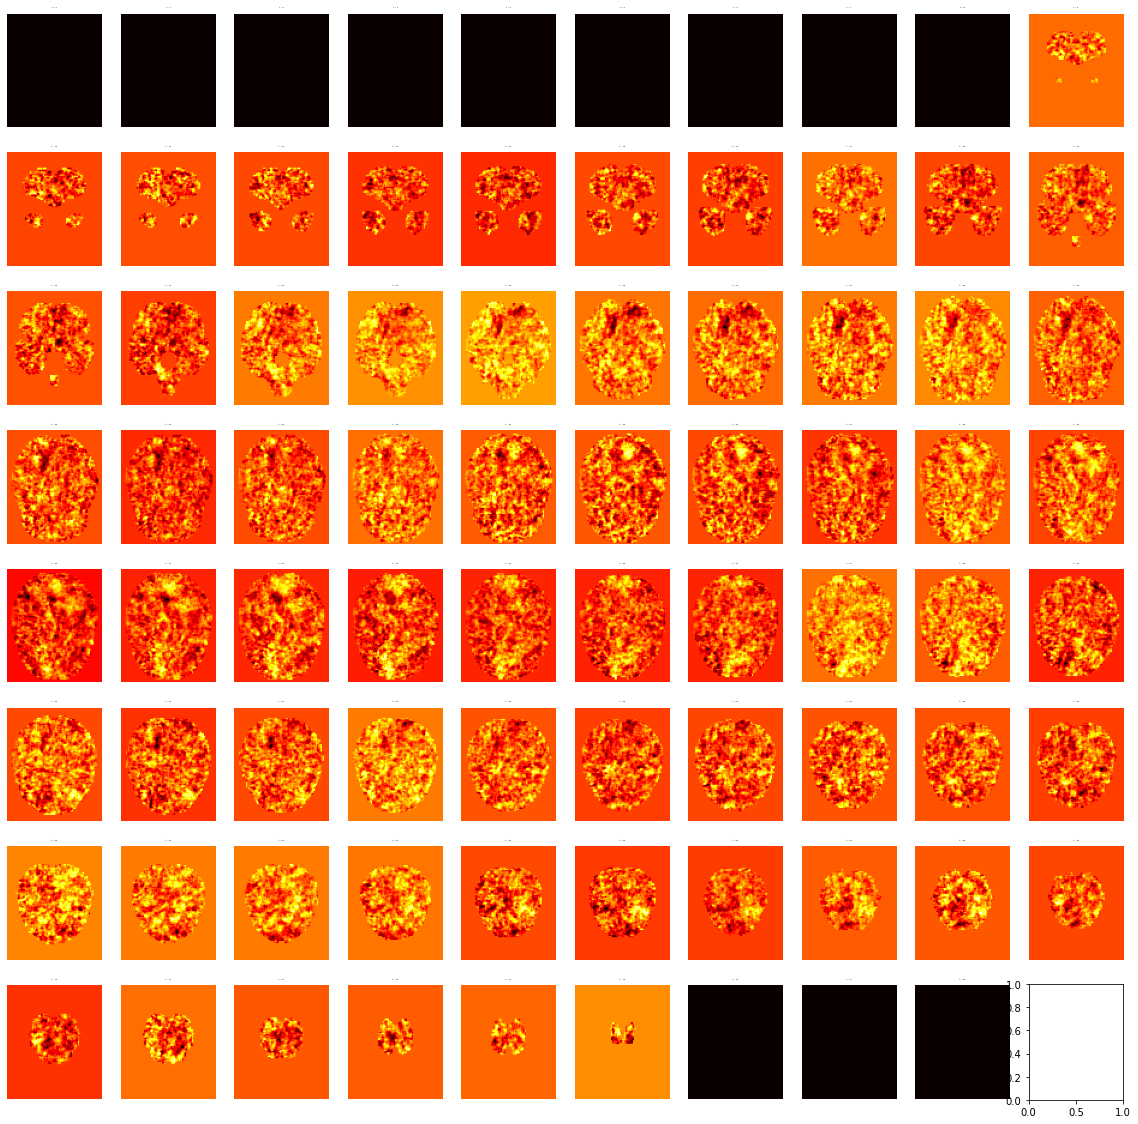

In [51]:
from matplotlib import patches
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=10, nrows=8, figsize=(20, 20))  # 20 timepoints
# Loop over the first 20 volumes/timepoints
for t, ax in enumerate(axes.flatten()):    
    ax.imshow(bmap2[:, :, t].T, cmap='hot')#, origin='lower')  # index with t!
    rect = patches.Rectangle((38, 20), 2, 2, linewidth=2, edgecolor='r', facecolor='black')
    #ax.add_patch(rect)
    ax.axis('off')
    ax.set_title('t = %i' % t, fontsize=2)
fig.set_facecolor("gray")
fig.tight_layout()

In [18]:
## Cross Validation accuracy scores recorded

dictionary = {"Cross Validation Young Adult Train run 2/Test run 3": ["1","2","3","4","5","Average"], "Unnormalized": [.49, .54, .51, .49, .50, .51],
              "PSC per run": [.49, .61, .60, .62, .50, .56 ], "PSC + Z Norm per Run": [.77, .76, .82, .79, .80, .79],
              "Z Norm per Run (No PSC)": [.77, .75, .82, .81, .80, .79]}

df = pd.DataFrame(dictionary)
df.set_index("Cross Validation Young Adult Train run 2/Test run 3", inplace = True)
df

,Unnormalized,PSC per run,PSC + Z Norm per Run,Z Norm per Run (No PSC)
Cross Validation Young Adult Train run 2/Test run 3,,,,
1,0.49,0.49,0.77,0.77
2,0.54,0.61,0.76,0.75
3,0.51,0.60,0.82,0.82
4,0.49,0.62,0.79,0.81
5,0.50,0.50,0.80,0.80
Average,0.51,0.56,0.79,0.79
